In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
# ✅ STEP 0: Import Libraries and Configure GPU

# Configure GPU memory growth before anything else
import tensorflow as tf

try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU memory growth successfully set.")
except RuntimeError as e:
    print("⚠️ Could not set memory growth:", e)

# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras components
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score

print("✅ STEP 0 completed successfully. Proceeding to STEP 1...")


⚠️ Could not set memory growth: Physical devices cannot be modified after being initialized
✅ STEP 0 completed successfully. Proceeding to STEP 1...


In [36]:
# ✅ STEP 1: Defining dataset paths and model parameters...
import os

print("✅ STEP 1: Defining dataset paths and model parameters...")

# Dataset paths from mbilal's dataset
REAL_DIR = "/kaggle/input/200k-real-vs-ai-visuals-by-mbilal/my_real_vs_ai_dataset/my_real_vs_ai_dataset/real"
AI_DIR   = "/kaggle/input/200k-real-vs-ai-visuals-by-mbilal/my_real_vs_ai_dataset/my_real_vs_ai_dataset/ai_images"

# CSV paths
train_csv = '/kaggle/input/200k-real-vs-ai-visuals-by-mbilal/train_labels.csv'
val_csv   = '/kaggle/input/200k-real-vs-ai-visuals-by-mbilal/val_labels.csv'
test_csv  = '/kaggle/input/200k-real-vs-ai-visuals-by-mbilal/test_labels.csv'

# Model save path
MODEL_SAVE_PATH = "best_efficientnet_model.keras"

# Image and training settings
IMAGE_SIZE = (240, 240)   # ✅ Now consistent with EfficientNetB4/B5 if needed
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNE_EPOCHS = 10
PATIENCE = 5

print("✅ STEP 1 Completed. Proceeding to STEP 2: Create ImageDataGenerators and Load Dataset...")


✅ STEP 1: Defining dataset paths and model parameters...
✅ STEP 1 Completed. Proceeding to STEP 2: Create ImageDataGenerators and Load Dataset...


In [37]:
print("✅ STEP 2: Loading dataset and preparing tf.data pipelines...")

import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# === ✅ Load CSVs
train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df  = pd.read_csv(test_csv)

# === ✅ Build full image paths
def build_path(filename):
    return os.path.join(REAL_DIR if 'real' in filename else AI_DIR, filename)

train_df['filepath'] = train_df['filename'].apply(build_path)
val_df['filepath']   = val_df['filename'].apply(build_path)
test_df['filepath']  = test_df['filename'].apply(build_path)

# === ✅ Encode labels: 'real' -> 0, 'ai' -> 1
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
val_df['label']   = label_encoder.transform(val_df['label'])
test_df['label']  = label_encoder.transform(test_df['label'])

# === ✅ Preprocessing function
def preprocess_image(path, label, img_size=(240, 240)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# === ✅ Dataset creator function
def prepare_dataset(paths, labels, img_size=(240, 240), batch_size=64, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(lambda x, y: preprocess_image(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# === ✅ Build datasets
train_ds = prepare_dataset(train_df['filepath'].values, train_df['label'].values, img_size=IMAGE_SIZE, shuffle=True)
val_ds   = prepare_dataset(val_df['filepath'].values, val_df['label'].values, img_size=IMAGE_SIZE, shuffle=False)
test_ds  = prepare_dataset(test_df['filepath'].values, test_df['label'].values, img_size=IMAGE_SIZE, shuffle=False)

print("✅ STEP 2 Completed. Datasets are ready for training.")


✅ STEP 2: Loading dataset and preparing tf.data pipelines...
✅ STEP 2 Completed. Datasets are ready for training.


In [40]:
# ✅ Remove rows with missing files
def filter_missing_images(df):
    return df[df['filepath'].apply(os.path.exists)].reset_index(drop=True)

train_df = filter_missing_images(train_df)
val_df   = filter_missing_images(val_df)
test_df  = filter_missing_images(test_df)

print(f"✅ Filtered datasets:")
print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")


✅ Filtered datasets:
Train: 78351
Val: 22355
Test: 11153


In [41]:
print("✅ STEP 3: Building EfficientNetB4 model...")

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# ✅ Enable mixed precision for TPU/GPUs
mixed_precision.set_global_policy('mixed_float16')

# ✅ Model input and base
inputs = Input(shape=(240, 240, 3))
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False  # Phase 1: Freeze base model

# ✅ Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid', dtype='float32')(x)  # force float32 output

# ✅ Final model
model = Model(inputs, outputs)

# ✅ Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ✅ Show summary
model.summary()
print("✅ STEP 3 Completed. Ready for STEP 4: Training Phase 1 🚀")


✅ STEP 3: Building EfficientNetB4 model...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 240, 240, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_12 (Cast)            │ (None, 240, 240, 3)    │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ cast_12[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 240, 240, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 241, 241, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 120, 120, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 120, 120, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 120, 120, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 120, 120, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 120, 120, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 120, 120, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 17,903,456 (68.30 MB)

 Trainable params: 229,633 (897.00 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

✅ STEP 3 Completed. Ready for STEP 4: Training Phase 1 🚀


In [42]:
print("✅ STEP 4: Training Phase 1 Starting...")

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ✅ Dataset builder
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [240, 240])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def prepare_dataset(paths, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# ✅ Rebuild datasets
train_ds = prepare_dataset(train_df['filepath'].values, train_df['label'].values, shuffle=True)
val_ds   = prepare_dataset(val_df['filepath'].values, val_df['label'].values, shuffle=False)

# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("efficientnetb4_phase1.keras", save_best_only=True)

# ✅ Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

print("✅ STEP 4 Completed: Phase 1 training finished.")


✅ STEP 4: Training Phase 1 Starting...
Epoch 1/30
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 321s 107ms/step - accuracy: 0.8916 - auc: 0.6019 - loss: 0.3392 - val_accuracy: 0.8947 - val_auc: 0.8045 - val_loss: 0.2975
Epoch 2/30
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 170s 69ms/step - accuracy: 0.8934 - auc: 0.7039 - loss: 0.3125 - val_accuracy: 0.8944 - val_auc: 0.8050 - val_loss: 0.2900
Epoch 3/30
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 166s 68ms/step - accuracy: 0.8924 - auc: 0.7033 - loss: 0.3147 - val_accuracy: 0.8944 - val_auc: 0.8065 - val_loss: 0.2911
Epoch 4/30
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 168s 68ms/step - accuracy: 0.8933 - auc: 0.7159 - loss: 0.3088 - val_accuracy: 0.8943 - val_auc: 0.8069 - val_loss: 0.2878
Epoch 5/30
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 172s 70ms/step - accuracy: 0.8933 - auc: 0.7212 - loss: 0.3082 - val_accuracy: 0.8947 - val_auc: 0.8081 - val_loss: 0.2875
Epoch 6/30
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 165s 67ms/step - accuracy: 0.8930 - auc: 0.7255 - loss: 0.3075 - val_accuracy: 0.8950 - val_a

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Define the model
input_shape = (240, 240, 3)
inputs = Input(shape=input_shape)

# ✅ Load pretrained EfficientNetB4 base
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False  # Phase 1: freeze base

# ✅ Classification head with anti-overfitting layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)                  # Regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)                  # More regularization
outputs = Dense(1, activation='sigmoid', dtype='float32')(x)

# ✅ Build model
model = Model(inputs, outputs)

# ✅ Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 240, 240, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_14 (Cast)            │ (None, 240, 240, 3)    │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_8 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ cast_14[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 240, 240, 3)    │              7 │ rescaling_8[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ normalization_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 241, 241, 3)    │              0 │ rescaling_9[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 120, 120, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 120, 120, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 120, 120, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 120, 120, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 120, 120, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 120, 120, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 18,133,088 (69.17 MB)

 Trainable params: 459,265 (1.75 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [44]:
print("✅ STEP 5: Starting Phase 2 – Fine-tuning the full model...")

# ✅ Unfreeze base model
base_model.trainable = True

# ✅ Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ✅ Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6),
    ModelCheckpoint("efficientnetb4_finetuned.keras", save_best_only=True, monitor='val_auc', mode='max')
]

# ✅ Fine-tune the full model
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # You can increase this if needed
    callbacks=callbacks
)

print("✅ STEP 5 Completed: Fine-tuning done. Best model saved.")


✅ STEP 5: Starting Phase 2 – Fine-tuning the full model...
Epoch 1/10
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 785s 239ms/step - accuracy: 0.8402 - auc: 0.8772 - loss: 0.3110 - val_accuracy: 0.9087 - val_auc: 0.9506 - val_loss: 0.1486 - learning_rate: 1.0000e-05
Epoch 2/10
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 491s 201ms/step - accuracy: 0.9123 - auc: 0.9550 - loss: 0.1448 - val_accuracy: 0.9123 - val_auc: 0.9553 - val_loss: 0.1407 - learning_rate: 1.0000e-05
Epoch 3/10
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 488s 199ms/step - accuracy: 0.9200 - auc: 0.9628 - loss: 0.1337 - val_accuracy: 0.9065 - val_auc: 0.9400 - val_loss: 0.1842 - learning_rate: 1.0000e-05
Epoch 4/10
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 484s 197ms/step - accuracy: 0.9323 - auc: 0.9712 - loss: 0.1224 - val_accuracy: 0.9108 - val_auc: 0.9372 - val_loss: 0.2003 - learning_rate: 1.0000e-05
Epoch 5/10
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 488s 199ms/step - accuracy: 0.9435 - auc: 0.9781 - loss: 0.1099 - val_accuracy: 0.9264 - val_auc: 0.9666 - val_loss: 0.1324

In [45]:
model.save("efficientnetb4_finetuned_final.keras")


✅ STEP 6: Final model evaluation...
175/175 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.9086 - auc: 0.8767 - loss: 0.2076

🎯 Test Accuracy: 0.9391
🎯 Test Loss:     0.1192
🎯 Test AUC:      0.9762
175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step

📊 Classification Report:
              precision    recall  f1-score   support

        REAL       0.98      0.95      0.97     10000
        FAKE       0.67      0.82      0.73      1153

    accuracy                           0.94     11153
   macro avg       0.82      0.88      0.85     11153
weighted avg       0.95      0.94      0.94     11153



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


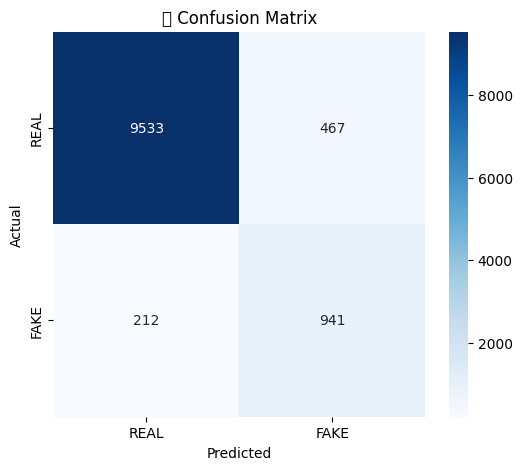

In [49]:
print("✅ STEP 6: Final model evaluation...")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# ✅ 6.1: Rebuild test dataset (no img_size arg needed if it's fixed internally)
test_ds = prepare_dataset(
    test_df['filepath'].values,
    test_df['label'].values,
    batch_size=64,
    shuffle=False
)

# ✅ 6.2: Evaluate on test set
test_loss, test_accuracy, test_auc = model.evaluate(test_ds)
print(f"\n🎯 Test Accuracy: {test_accuracy:.4f}")
print(f"🎯 Test Loss:     {test_loss:.4f}")
print(f"🎯 Test AUC:      {test_auc:.4f}")

# ✅ 6.3: Predict on test set
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = test_df['label'].values

# ✅ 6.4: Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['REAL', 'FAKE']))

# ✅ 6.5: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧠 Confusion Matrix")
plt.show()


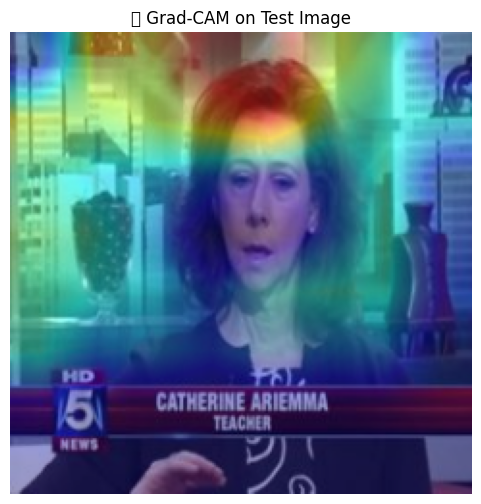

In [52]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# ✅ Function to compute Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ✅ Select a sample image path from the test set
sample_path = test_df.iloc[0]['filepath']

# ✅ Preprocess the image
img = tf.keras.preprocessing.image.load_img(sample_path, target_size=(240, 240))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# ✅ Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv")

# ✅ Prepare heatmap and overlay on original image
heatmap_resized = cv2.resize(np.uint8(255 * heatmap), (240, 240))
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

original_img = cv2.imread(sample_path)
original_img = cv2.resize(original_img, (240, 240))

superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

# ✅ Display result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("🧠 Grad-CAM on Test Image")
plt.show()


# *STEP 7: Save and Load the Final Model*

In [53]:
# ✅ Save the final model
model.save("efficientnetb4_final_model.keras")
print("✅ Model saved as efficientnetb4_final_model.keras")

# ✅ Load it anytime later
from tensorflow.keras.models import load_model
model = load_model("efficientnetb4_final_model.keras")
print("✅ Model loaded successfully")


✅ Model saved as efficientnetb4_final_model.keras
✅ Model loaded successfully


# *STEP 8: Plot Training History*

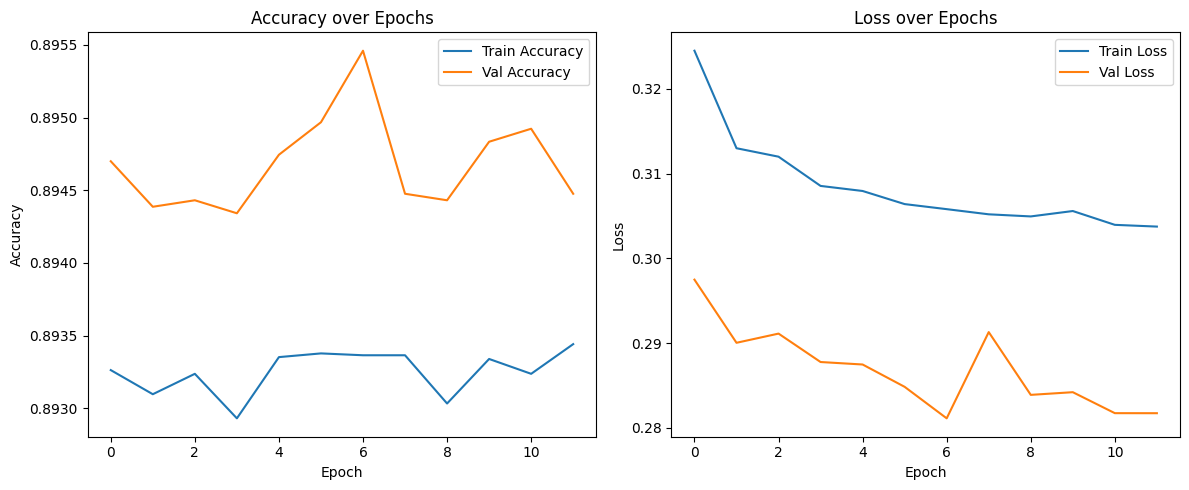

In [54]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


#  9: Export Predictions (optional)


In [55]:
# Generate predictions
pred_probs = model.predict(test_ds)
pred_labels = (pred_probs > 0.5).astype("int").flatten()

# Add predictions to DataFrame
test_df["predicted_prob"] = pred_probs.flatten()
test_df["predicted_label"] = pred_labels
test_df.to_csv("test_predictions.csv", index=False)

print("✅ Predictions saved to test_predictions.csv")


175/175 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step
✅ Predictions saved to test_predictions.csv


# STEP 11: Build Ensemble Model B5


In [57]:
print("✅ STEP 11: Building EfficientNetB5 Model...")

from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# ✅ Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Input layer
input_shape = (240, 240, 3)
inputs = Input(shape=input_shape)

# ✅ Load EfficientNetB5 base
base_model = EfficientNetB5(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False  # Freeze base for Phase 1

# ✅ Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)               # Regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid', dtype='float32')(x)

# ✅ Build the model
model_b5 = Model(inputs, outputs)

# ✅ Compile the model
model_b5.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ✅ Summary
model_b5.summary()
print("✅ STEP 11 Completed. Proceed to STEP 12: Training Phase 1...")


✅ STEP 11: Building EfficientNetB5 Model...
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 240, 240, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_20 (Cast)            │ (None, 240, 240, 3)    │              0 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_10 (Rescaling)  │ (None, 240, 240, 3)    │              0 │ cast_20[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_5           │ (None, 240, 240, 3)    │              7 │ rescaling_10[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_11 (Rescaling)  │ (None, 240, 240, 3)    │              0 │ normalization_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 241, 241, 3)    │              0 │ rescaling_11[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 120, 120, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 120, 120, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 120, 120, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 120, 120, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 120, 120, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 120, 120, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 29,038,328 (110.77 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

✅ STEP 11 Completed. Proceed to STEP 12: Training Phase 1...


In [58]:
print("✅ STEP 12: Training EfficientNetB5 - Phase 1...")

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ✅ Callbacks
checkpoint_cb = ModelCheckpoint(
    "efficientnetb5_model_phase1.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ✅ Class weights (you can update if imbalance is detected)
class_weights = {0: 1.0, 1: 1.0}

# ✅ Train the model
history_b5_phase1 = model_b5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb],
    class_weight=class_weights,
    verbose=1
)

print("✅ STEP 12 Completed. Proceed to STEP 13: Fine-tuning EfficientNetB5...")


✅ STEP 12: Training EfficientNetB5 - Phase 1...
Epoch 1/30
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8900 - auc: 0.6780 - loss: 0.3239
Epoch 1: val_loss improved from inf to 0.29125, saving model to efficientnetb5_model_phase1.keras
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 350s 115ms/step - accuracy: 0.8900 - auc: 0.6780 - loss: 0.3239 - val_accuracy: 0.8951 - val_auc: 0.8093 - val_loss: 0.2912
Epoch 2/30
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8931 - auc: 0.7401 - loss: 0.3032
Epoch 2: val_loss improved from 0.29125 to 0.28026, saving model to efficientnetb5_model_phase1.keras
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 228s 93ms/step - accuracy: 0.8931 - auc: 0.7401 - loss: 0.3032 - val_accuracy: 0.8952 - val_auc: 0.8161 - val_loss: 0.2803
Epoch 3/30
2448/2449 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8921 - auc: 0.7462 - loss: 0.3028
Epoch 3: val_loss did not improve from 0.28026
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 226s 92ms/step - accuracy: 0.8921 - auc: 0.7462 - loss: 

In [59]:
print("✅ STEP 13: Fine-tuning EfficientNetB5...")

# ✅ Unfreeze the entire model
model_b5.trainable = True

# ✅ Re-compile with lower learning rate
model_b5.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ✅ Callbacks
checkpoint_cb_ft = ModelCheckpoint(
    "efficientnetb5_model_finetuned.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

earlystop_cb_ft = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ✅ Fine-tune the model
history_b5_phase2 = model_b5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb_ft, earlystop_cb_ft],
    class_weight=class_weights,
    verbose=1
)

print("✅ STEP 13 Completed. Proceed to STEP 14: Evaluation and Visualization...")


✅ STEP 13: Fine-tuning EfficientNetB5...
Epoch 1/10
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8928 - auc: 0.7697 - loss: 0.2916
Epoch 1: val_loss improved from inf to 0.27132, saving model to efficientnetb5_model_finetuned.keras
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 343s 113ms/step - accuracy: 0.8928 - auc: 0.7697 - loss: 0.2916 - val_accuracy: 0.8946 - val_auc: 0.8346 - val_loss: 0.2713
Epoch 2/10
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8944 - auc: 0.7692 - loss: 0.2895
Epoch 2: val_loss improved from 0.27132 to 0.26954, saving model to efficientnetb5_model_finetuned.keras
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 230s 94ms/step - accuracy: 0.8944 - auc: 0.7692 - loss: 0.2895 - val_accuracy: 0.8946 - val_auc: 0.8352 - val_loss: 0.2695
Epoch 3/10
2448/2449 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8914 - auc: 0.7696 - loss: 0.2940
Epoch 3: val_loss improved from 0.26954 to 0.26881, saving model to efficientnetb5_model_finetuned.keras
2449/2449 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# ✅ ADVANCED B5 FINE-TUNING
print("\n✅ STEP 13.1: Partial unfreezing & improved learning schedule...")

from tensorflow.keras.optimizers.schedules import CosineDecay

# Unfreeze last 30 layers (excluding BatchNorm)
unfrozen_layers = 0
for layer in model_b5.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
        unfrozen_layers += 1
print(f"✅ Unfroze last {unfrozen_layers} trainable layers.")

# Cosine decay learning rate
steps_per_epoch = len(train_ds)
lr_schedule = CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=10 * steps_per_epoch,
    alpha=1e-6
)

# Recompile with updated learning rate and label smoothing
model_b5.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Re-train with early stopping
early_stop_2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_b5_finetune = model_b5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop_2],
    class_weight=class_weights
)

print("\n✅ STEP 13.1 Completed. Continue to STEP 14 for evaluation.")



✅ STEP 13.1: Partial unfreezing & improved learning schedule...
✅ Unfroze last 25 trainable layers.
Epoch 1/15
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 379s 125ms/step - accuracy: 0.8936 - auc: 0.7468 - loss: 0.3923 - val_accuracy: 0.8960 - val_auc: 0.8679 - val_loss: 0.3607
Epoch 2/15
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 254s 103ms/step - accuracy: 0.8931 - auc: 0.8088 - loss: 0.3742 - val_accuracy: 0.8949 - val_auc: 0.8910 - val_loss: 0.3500
Epoch 3/15
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 256s 104ms/step - accuracy: 0.8968 - auc: 0.8368 - loss: 0.3617 - val_accuracy: 0.8970 - val_auc: 0.8920 - val_loss: 0.3452
Epoch 4/15
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 254s 104ms/step - accuracy: 0.8958 - auc: 0.8495 - loss: 0.3606 - val_accuracy: 0.8954 - val_auc: 0.9037 - val_loss: 0.3485
Epoch 5/15
2449/2449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8942 - auc: 0.8534 - loss: 0.3598